In [1]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx

import numpy as np
np.random.seed(1)
from tensorflow import set_random_seed 
set_random_seed(2)

from keras import backend as K

from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf 
from keras import metrics
from keras.callbacks import ModelCheckpoint

import pandas as pd 
import math as m
import os, glob

Using TensorFlow backend.


In [167]:

RANGE = 51

HYPER_L1_IN = RANGE
EPOCHS = 10
BATCH_SIZE = 32

TEST_SIZE = .19
VAL_SIZE = .0

START_IN = 50000
#total 99380

END_IN = 60000

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [168]:
#LOAD DATASET for ASK
# change column names
#load Dataset for BID
#change column names

cwd = os.getcwd()
source_data = os.path.join(cwd, r'../../Datasets/EURUSD/ene2004_nov2019/')
filenames = glob.glob(source_data + "/*.csv")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y %H:%M:%S.%f')
DF_EURUSD_ASK = pd.read_csv(filenames[0], parse_dates=['Gmt time'], date_parser=dateparse, index_col=None, header=0)
print(DF_EURUSD_ASK.columns)
DF_EURUSD_ASK.rename(columns={'Gmt time':'timestamp',
                             'Open':'open_ask',
                             'High':'high_ask',
                             'Low':'low_ask',
                             'Close':'close_ask',
                             'Volume':'volume_ask'},
                    inplace=True)
print(DF_EURUSD_ASK.columns)

print(DF_EURUSD_ASK.head())
print(DF_EURUSD_ASK.tail())



EURUSD_ASK_01.01.2004-19.11.2019.csv
Index(['Gmt time', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
Index(['timestamp', 'open_ask', 'high_ask', 'low_ask', 'close_ask',
       'volume_ask'],
      dtype='object')
            timestamp  open_ask  high_ask  low_ask  close_ask  volume_ask
0 2004-01-01 00:00:00   1.25950   1.25960  1.25826    1.25910   6654.2002
1 2004-01-01 01:00:00   1.25958   1.25960  1.25947    1.25951    660.6000
2 2004-01-01 02:00:00   1.25955   1.25962  1.25944    1.25951   2091.0000
3 2004-01-01 03:00:00   1.25950   1.25965  1.25834    1.25869  10003.0996
4 2004-01-01 04:00:00   1.25908   1.25960  1.25843    1.25950   7603.3999
                timestamp  open_ask  high_ask  low_ask  close_ask  volume_ask
99425 2019-11-29 17:00:00   1.10192   1.10230  1.10163    1.10163   7553.0898
99426 2019-11-29 18:00:00   1.10164   1.10236  1.10162    1.10173   3899.8999
99427 2019-11-29 19:00:00   1.10173   1.10179  1.10163    1.10176   5099.0898
99428 2019-11-29 

In [169]:
print(DF_EURUSD_ASK.shape)
#DF_EURUSD_ASK2 = DF_EURUSD_ASK.iloc[3500:]
#DF_EURUSD_ASK2 = DF_EURUSD_ASK
print(DF_EURUSD_ASK.shape)


(99430, 6)
(99430, 6)


In [170]:
#Describe Dataframe ASK

print('Shape: ', DF_EURUSD_ASK.shape)
print(DF_EURUSD_ASK.describe())
#print(DF_EURUSD_ASK.head())
#date_series = pd.to_datetime(DF_EURUSD_ASK['timestamp'][0])
DF_EURUSD_ASK = DF_EURUSD_ASK.drop(['timestamp'], axis = 1)
print(DF_EURUSD_ASK)


Shape:  (99430, 6)
           open_ask      high_ask       low_ask     close_ask     volume_ask
count  99430.000000  99430.000000  99430.000000  99430.000000   99430.000000
mean       1.269150      1.270197      1.268104      1.269151   21093.432064
std        0.121170      0.121347      0.120974      0.121171   33100.675536
min        1.035600      1.037040      1.034050      1.035630       0.380000
25%        1.168492      1.169320      1.167715      1.168473    5057.005000
50%        1.275570      1.276725      1.274450      1.275580   11830.814950
75%        1.353180      1.354100      1.352300      1.353170   25370.099600
max        1.601460      1.604030      1.598830      1.601570  491584.312500
       open_ask  high_ask  low_ask  close_ask  volume_ask
0       1.25950   1.25960  1.25826    1.25910   6654.2002
1       1.25958   1.25960  1.25947    1.25951    660.6000
2       1.25955   1.25962  1.25944    1.25951   2091.0000
3       1.25950   1.25965  1.25834    1.25869  10003.099

In [171]:
def EMA(df, n):
    EMA = pd.Series(DF_EURUSD_ASK['close_ask'].ewm(com=0.5).mean(), name = 'EMA_' + str(n))
    df = df.join(EMA)  
    return df

In [172]:
DF_EURUSD_ASK = EMA(DF_EURUSD_ASK, 5)
DF_EURUSD_ASK = EMA(DF_EURUSD_ASK, 25)
DF_EURUSD_ASK = EMA(DF_EURUSD_ASK, 50)
print(DF_EURUSD_ASK.tail(5))

       open_ask  high_ask  low_ask  close_ask  volume_ask     EMA_5    EMA_25  \
99425   1.10192   1.10230  1.10163    1.10163   7553.0898  1.101710  1.101710   
99426   1.10164   1.10236  1.10162    1.10173   3899.8999  1.101723  1.101723   
99427   1.10173   1.10179  1.10163    1.10176   5099.0898  1.101748  1.101748   
99428   1.10177   1.10182  1.10165    1.10168   2065.7600  1.101703  1.101703   
99429   1.10170   1.10242  1.10159    1.10213   2305.5830  1.101988  1.101988   

         EMA_50  
99425  1.101710  
99426  1.101723  
99427  1.101748  
99428  1.101703  
99429  1.101988  


In [173]:
#Moving Average  
def MA(df, n): 
    MA = pd.Series(df['close_ask'].rolling(n).mean(), name = 'MA_' + str(n)) 
    df = df.join(MA)  
    return df


In [174]:
DF_EURUSD_ASK = MA(DF_EURUSD_ASK, 5)
DF_EURUSD_ASK = MA(DF_EURUSD_ASK, 25)
DF_EURUSD_ASK = MA(DF_EURUSD_ASK, 50)
print(DF_EURUSD_ASK.head(10))
print(DF_EURUSD_ASK.tail(10))

   open_ask  high_ask  low_ask  close_ask  volume_ask     EMA_5    EMA_25  \
0   1.25950   1.25960  1.25826    1.25910   6654.2002  1.259100  1.259100   
1   1.25958   1.25960  1.25947    1.25951    660.6000  1.259408  1.259408   
2   1.25955   1.25962  1.25944    1.25951   2091.0000  1.259478  1.259478   
3   1.25950   1.25965  1.25834    1.25869  10003.0996  1.258946  1.258946   
4   1.25908   1.25960  1.25843    1.25950   7603.3999  1.259317  1.259317   
5   1.25907   1.25960  1.25825    1.25955  10862.5996  1.259473  1.259473   
6   1.25914   1.25960  1.25482    1.25948  10160.4004  1.259478  1.259478   
7   1.25938   1.25950  1.24698    1.25910  13008.2002  1.259226  1.259226   
8   1.25900   1.25953  1.25726    1.25907   5518.8999  1.259122  1.259122   
9   1.25915   1.25953  1.25864    1.25917   7611.2002  1.259154  1.259154   

     EMA_50      MA_5  MA_25  MA_50  
0  1.259100       NaN    NaN    NaN  
1  1.259408       NaN    NaN    NaN  
2  1.259478       NaN    NaN    NaN  


In [130]:
#Momentum  
def MOM(df, n):  
    M = pd.Series(df['close_ask'].diff(n), name = 'Momentum_' + str(n))  
    df = df.join(M)  
    return df

In [131]:
DF_EURUSD_ASK = MOM(DF_EURUSD_ASK, 5)
DF_EURUSD_ASK = MOM(DF_EURUSD_ASK, 25)
DF_EURUSD_ASK = MOM(DF_EURUSD_ASK, 50)
print(DF_EURUSD_ASK.tail(5))

       open_ask  high_ask  low_ask  close_ask  volume_ask     EMA_5    EMA_25  \
99425   1.10192   1.10230  1.10163    1.10163   7553.0898  1.101710  1.101710   
99426   1.10164   1.10236  1.10162    1.10173   3899.8999  1.101723  1.101723   
99427   1.10173   1.10179  1.10163    1.10176   5099.0898  1.101748  1.101748   
99428   1.10177   1.10182  1.10165    1.10168   2065.7600  1.101703  1.101703   
99429   1.10170   1.10242  1.10159    1.10213   2305.5830  1.101988  1.101988   

         EMA_50      MA_5     MA_25     MA_50  Momentum_5  Momentum_25  \
99425  1.101710  1.101124  1.100876  1.100747     0.00197      0.00099   
99426  1.101723  1.101618  1.100912  1.100778     0.00247      0.00091   
99427  1.101748  1.101960  1.100947  1.100813     0.00171      0.00087   
99428  1.101703  1.101742  1.100978  1.100844    -0.00109      0.00077   
99429  1.101988  1.101786  1.101026  1.100877     0.00022      0.00121   

       Momentum_50  
99425      0.00174  
99426      0.00157  
99427

In [132]:
#Rate of Change  
def ROC(df, n):  
    M = df['close_ask'].diff(n - 1)  
    N = df['close_ask'].shift(n - 1)  
    ROC = pd.Series(M / N, name = 'ROC_' + str(n))  
    df = df.join(ROC)  
    return df

In [133]:
DF_EURUSD_ASK = ROC(DF_EURUSD_ASK, 5)
print(DF_EURUSD_ASK.tail(5))

       open_ask  high_ask  low_ask  close_ask  volume_ask     EMA_5    EMA_25  \
99425   1.10192   1.10230  1.10163    1.10163   7553.0898  1.101710  1.101710   
99426   1.10164   1.10236  1.10162    1.10173   3899.8999  1.101723  1.101723   
99427   1.10173   1.10179  1.10163    1.10176   5099.0898  1.101748  1.101748   
99428   1.10177   1.10182  1.10165    1.10168   2065.7600  1.101703  1.101703   
99429   1.10170   1.10242  1.10159    1.10213   2305.5830  1.101988  1.101988   

         EMA_50      MA_5     MA_25     MA_50  Momentum_5  Momentum_25  \
99425  1.101710  1.101124  1.100876  1.100747     0.00197      0.00099   
99426  1.101723  1.101618  1.100912  1.100778     0.00247      0.00091   
99427  1.101748  1.101960  1.100947  1.100813     0.00171      0.00087   
99428  1.101703  1.101742  1.100978  1.100844    -0.00109      0.00077   
99429  1.101988  1.101786  1.101026  1.100877     0.00022      0.00121   

       Momentum_50     ROC_5  
99425      0.00174  0.002156  
99426 

In [135]:
#Average True Range  
def ATR(df, n):  
    i = 0  
    TR_l = [0]  
    while i < df.index[-1]:  
        TR = max(df.get_value(i + 1, 'high_ask'), df.get_value(i, 'close_ask')) - min(df.get_value(i + 1, 'low_ask'), df.get_value(i, 'close_ask'))  
        TR_l.append(TR)  
        i = i + 1  
    TR_s = pd.Series(TR_l)  
    ATR = pd.Series(df['close_ask'].ewm(com=n).mean(), name = 'ATR_' + str(n))  
    df = df.join(ATR)  
    return df

In [136]:
DF_EURUSD_ASK = ATR(DF_EURUSD_ASK, 1)
print(DF_EURUSD_ASK.tail(5))

/Users/marami3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


       open_ask  high_ask  low_ask  close_ask  volume_ask     EMA_5    EMA_25  \
99425   1.10192   1.10230  1.10163    1.10163   7553.0898  1.101710  1.101710   
99426   1.10164   1.10236  1.10162    1.10173   3899.8999  1.101723  1.101723   
99427   1.10173   1.10179  1.10163    1.10176   5099.0898  1.101748  1.101748   
99428   1.10177   1.10182  1.10165    1.10168   2065.7600  1.101703  1.101703   
99429   1.10170   1.10242  1.10159    1.10213   2305.5830  1.101988  1.101988   

         EMA_50      MA_5     MA_25     MA_50  Momentum_5  Momentum_25  \
99425  1.101710  1.101124  1.100876  1.100747     0.00197      0.00099   
99426  1.101723  1.101618  1.100912  1.100778     0.00247      0.00091   
99427  1.101748  1.101960  1.100947  1.100813     0.00171      0.00087   
99428  1.101703  1.101742  1.100978  1.100844    -0.00109      0.00077   
99429  1.101988  1.101786  1.101026  1.100877     0.00022      0.00121   

       Momentum_50     ROC_5     ATR_1  
99425      0.00174  0.00215

In [137]:
#Bollinger Bands  
def BBANDS(df, n):  
    MA = pd.Series(pd.Series(df['close_ask'].rolling(n).mean()))  
    MSD = pd.Series(pd.Series(df['close_ask'].rolling(n).std()))  
    b1 = 4 * MSD / MA  
    B1 = pd.Series(b1, name = 'BollingerB_' + str(n))  
    df = df.join(B1)  
    b2 = (df['close_ask'] - MA + 2 * MSD) / (4 * MSD)  
    B2 = pd.Series(b2, name = 'Bollingerb_' + str(n))  
    df = df.join(B2)  
    return df

In [138]:
DF_EURUSD_ASK = BBANDS(DF_EURUSD_ASK, 5)
print(DF_EURUSD_ASK.tail(5))

       open_ask  high_ask  low_ask  close_ask  volume_ask     EMA_5    EMA_25  \
99425   1.10192   1.10230  1.10163    1.10163   7553.0898  1.101710  1.101710   
99426   1.10164   1.10236  1.10162    1.10173   3899.8999  1.101723  1.101723   
99427   1.10173   1.10179  1.10163    1.10176   5099.0898  1.101748  1.101748   
99428   1.10177   1.10182  1.10165    1.10168   2065.7600  1.101703  1.101703   
99429   1.10170   1.10242  1.10159    1.10213   2305.5830  1.101988  1.101988   

         EMA_50      MA_5     MA_25     MA_50  Momentum_5  Momentum_25  \
99425  1.101710  1.101124  1.100876  1.100747     0.00197      0.00099   
99426  1.101723  1.101618  1.100912  1.100778     0.00247      0.00091   
99427  1.101748  1.101960  1.100947  1.100813     0.00171      0.00087   
99428  1.101703  1.101742  1.100978  1.100844    -0.00109      0.00077   
99429  1.101988  1.101786  1.101026  1.100877     0.00022      0.00121   

       Momentum_50     ROC_5     ATR_1  BollingerB_5  Bollingerb_5  

In [147]:
#Pivot Points, Supports and Resistances  
def PPSR(df):  
    PP = pd.Series((df['high_ask'] + df['low_ask'] + df['close_ask']) / 3)  
    R1 = pd.Series(2 * PP - df['low_ask'])  
    S1 = pd.Series(2 * PP - df['high_ask'])  
    R2 = pd.Series(PP + df['high_ask'] - df['low_ask'])  
    S2 = pd.Series(PP - df['high_ask'] + df['low_ask'])  
    R3 = pd.Series(df['high_ask'] + 2 * (PP - df['low_ask']))  
    S3 = pd.Series(df['low_ask'] - 2 * (df['high_ask'] - PP))  
    psr = {'PP':PP, 'R1':R1, 'S1':S1, 'R2':R2, 'S2':S2, 'R3':R3, 'S3':S3}  
    PSR = pd.DataFrame(psr)  
    df = df.join(PSR)  
    return df

In [148]:
DF_EURUSD_ASK = PPSR(DF_EURUSD_ASK)
print(DF_EURUSD_ASK.tail(5))

       open_ask  high_ask  low_ask  close_ask  volume_ask     EMA_5    EMA_25  \
99425   1.10192   1.10230  1.10163    1.10163   7553.0898  1.101710  1.101710   
99426   1.10164   1.10236  1.10162    1.10173   3899.8999  1.101723  1.101723   
99427   1.10173   1.10179  1.10163    1.10176   5099.0898  1.101748  1.101748   
99428   1.10177   1.10182  1.10165    1.10168   2065.7600  1.101703  1.101703   
99429   1.10170   1.10242  1.10159    1.10213   2305.5830  1.101988  1.101988   

         EMA_50      MA_5     MA_25  ...     ATR_1  BollingerB_5  \
99425  1.101710  1.101124  1.100876  ...  1.101615      0.005205   
99426  1.101723  1.101618  1.100912  ...  1.101673      0.003578   
99427  1.101748  1.101960  1.100947  ...  1.101716      0.001684   
99428  1.101703  1.101742  1.100978  ...  1.101698      0.000385   
99429  1.101988  1.101786  1.101026  ...  1.101914      0.000721   

       Bollingerb_5        PP        R1        S1        R2        S2  \
99425      0.588292  1.101853  

In [175]:
#HERE~~~~~~~~~~~~~~~~~~~~~


print(DF_EURUSD_ASK.shape)
DF_loc = DF_EURUSD_ASK.iloc[50:]
print(DF_loc)
print(DF_loc.shape)

(99430, 11)
       open_ask  high_ask  low_ask  close_ask   volume_ask     EMA_5  \
50      1.26602   1.26654  1.26418    1.26534   27811.9004  1.265314   
51      1.26522   1.26605  1.26486    1.26605   25342.3008  1.265805   
52      1.26591   1.26712  1.26566    1.26616   26680.3008  1.266042   
53      1.26623   1.26658  1.26511    1.26554   25238.4004  1.265707   
54      1.26566   1.26688  1.26541    1.26634   25252.4004  1.266129   
55      1.26639   1.26935  1.26565    1.26847   28269.6992  1.267690   
56      1.26805   1.26841  1.26325    1.26354   25556.0996  1.264923   
57      1.26343   1.26567  1.26340    1.26527   26884.6992  1.265154   
58      1.26540   1.26802  1.26533    1.26662   28066.9004  1.266131   
59      1.26661   1.26889  1.26623    1.26807   27132.8008  1.267424   
60      1.26815   1.26838  1.26684    1.26709   27606.5000  1.267201   
61      1.26713   1.26733  1.26438    1.26454   26476.0000  1.265427   
62      1.26448   1.26729  1.26415    1.26661   2726

In [176]:
DF_Full = DF_loc
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
print(DF_Full.shape)
print(DF_Full.columns)
print(DF_Full.head(10))

(99380, 11)
Index(['open_ask', 'high_ask', 'low_ask', 'close_ask', 'volume_ask', 'EMA_5',
       'EMA_25', 'EMA_50', 'MA_5', 'MA_25', 'MA_50'],
      dtype='object')
   open_ask  high_ask  low_ask  close_ask  volume_ask     EMA_5    EMA_25  \
0   1.26602   1.26654  1.26418    1.26534  27811.9004  1.265314  1.265314   
1   1.26522   1.26605  1.26486    1.26605  25342.3008  1.265805  1.265805   
2   1.26591   1.26712  1.26566    1.26616  26680.3008  1.266042  1.266042   
3   1.26623   1.26658  1.26511    1.26554  25238.4004  1.265707  1.265707   
4   1.26566   1.26688  1.26541    1.26634  25252.4004  1.266129  1.266129   
5   1.26639   1.26935  1.26565    1.26847  28269.6992  1.267690  1.267690   
6   1.26805   1.26841  1.26325    1.26354  25556.0996  1.264923  1.264923   
7   1.26343   1.26567  1.26340    1.26527  26884.6992  1.265154  1.265154   
8   1.26540   1.26802  1.26533    1.26662  28066.9004  1.266131  1.266131   
9   1.26661   1.26889  1.26623    1.26807  27132.8008  1.267424 

In [179]:
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)
print('End: ', END_IN)


Total:  99380
Start:  50000
End:  60000


In [180]:
#Shape the first START of the total
DF_Full = DF_Full.iloc[START_IN:END_IN]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
print(DF_Full.shape)

(10000, 11)


In [181]:
total = DF_Full.shape[0]
print('Total: ', total)

Total:  10000


In [182]:
#generate the VECTOR Y
close_y = DF_Full['close_ask'].iloc[1:]
close_y.columns = ['close_y']
print(close_y.tail())
print(close_y.shape)
close_y = close_y.append(close_y.tail(1), ignore_index=True)
print(close_y.tail())
print(close_y.shape)


9995    1.32660
9996    1.32644
9997    1.32625
9998    1.32609
9999    1.32534
Name: close_ask, dtype: float64
(9999,)
9995    1.32644
9996    1.32625
9997    1.32609
9998    1.32534
9999    1.32534
Name: close_ask, dtype: float64
(10000,)


In [183]:
s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)



Sum of %s: 0.19
count of Val and Test: 1900
end of train:  8100
count val:  0
count test:  1900
end_val 8100


In [190]:
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print("Data Training Shape: ",data_training.shape)
print("Data Val Shape: ",data_val.shape)
print("Data Test Shape: ",data_test.shape)

data_training_y = close_y.iloc[:end_train]
data_val_y = close_y.iloc[end_train: end_val]
data_test_y = close_y.iloc[end_val:]
print("")
print("Y Data Training Shape: ", data_training_y.shape)
print("Y Data Val Shape: ", data_val_y.shape)
print("Y Data Test Shape: ", data_test_y.shape)

Data Training Shape:  (8100, 11)
Data Val Shape:  (0, 11)
Data Test Shape:  (1900, 11)

Y Data Training Shape:  (8100,)
Y Data Val Shape:  (0,)
Y Data Test Shape:  (1900,)


In [191]:
data_training_array = np.array(data_training)
#data_training_array = data_training_array.reset_index()
print(data_training_array.shape)
np.where(np.isnan(data_training_array))
#print(data_training_array.shape)
np.any(np.isnan(data_training_array))

(8100, 11)


False

In [192]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(0, 1))
#print(data_training.head)
#data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[0.54154239 0.53992372 0.54335401 ... 0.53769242 0.53948002 0.58520508]
 [0.53892507 0.53556511 0.5432324  ... 0.54027867 0.53923294 0.58339579]
 [0.53789032 0.5480356  0.54353642 ... 0.54639163 0.5398137  0.58193231]
 ...
 [0.68543429 0.68048913 0.68946856 ... 0.69213731 0.66015013 0.65520606]
 [0.68500822 0.68024699 0.68843488 ... 0.69197644 0.66338505 0.65618697]
 [0.68622558 0.68321327 0.69092789 ... 0.69227342 0.66683648 0.6572849 ]]


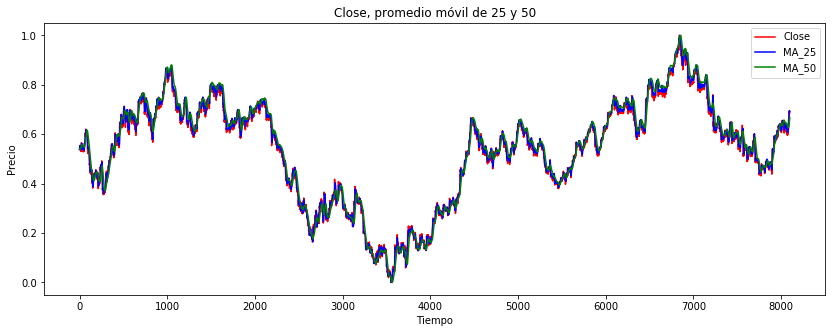

In [195]:
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[:,3], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[:,8], color = 'blue', label = 'MA_25')
pyplot.plot(data_training_array_scaled[:,9], color = 'green', label = 'MA_50')
plt.title('Close, promedio móvil de 25 y 50')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()

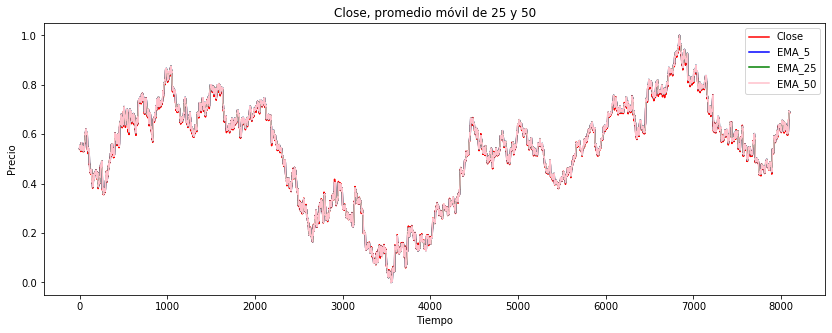

In [197]:
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[:,3], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[:,5], color = 'blue', label = 'EMA_5')
pyplot.plot(data_training_array_scaled[:,6], color = 'green', label = 'EMA_25')
pyplot.plot(data_training_array_scaled[:,7], color = 'pink', label = 'EMA_50')
plt.title('Close, promedio móvil de 25 y 50')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()

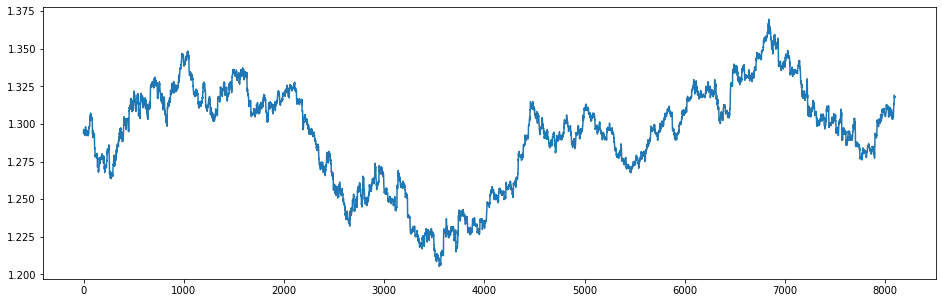

In [198]:
pyplot.figure(figsize=(16,5))
pyplot.plot(data_training_y)

In [199]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    X_train.append(data_training_array_scaled[i-RANGE:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(8049, 51, 11)
(8049,)


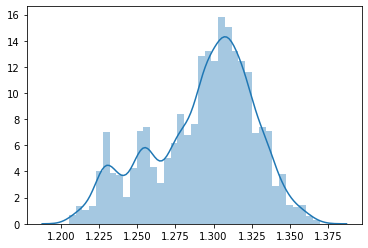

In [200]:
sns.distplot(y_train_np);



In [201]:

#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
print(data_val_x1.head)

(51, 11)
(0, 11)
<bound method NDFrame.head of     open_ask  high_ask  low_ask  close_ask  volume_ask     EMA_5    EMA_25  \
0    1.31060   1.31060  1.30965    1.30970   4542.3198  1.310031  1.310031   
1    1.30971   1.31053  1.30933    1.31016   6093.7402  1.310117  1.310117   
2    1.31017   1.31080  1.30970    1.31044   5527.2202  1.310332  1.310332   
3    1.31044   1.31045  1.30722    1.30766  11074.8896  1.308551  1.308551   
4    1.30768   1.30801  1.30655    1.30775   8956.7900  1.308017  1.308017   
5    1.30775   1.30803  1.30701    1.30795   6308.7598  1.307972  1.307972   
6    1.30794   1.30826  1.30733    1.30734   5873.0400  1.307551  1.307551   
7    1.30733   1.30805  1.30652    1.30763  10327.3301  1.307604  1.307604   
8    1.30762   1.30925  1.30663    1.30745  15402.4297  1.307501  1.307501   
9    1.30747   1.30753  1.30530    1.30543  15774.9199  1.306120  1.306120   
10   1.30544   1.30763  1.30544    1.30640  14817.8301  1.306307  1.306307   
11   1.30638   1.

In [202]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y.tail(RANGE)
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = last_range_train_y.append(data_val_y, ignore_index = True)
data_val_y1.shape
print(data_val_y1.head(10))

(51,)
(0,)
0    1.31016
1    1.31044
2    1.30766
3    1.30775
4    1.30795
5    1.30734
6    1.30763
7    1.30745
8    1.30543
9    1.30640
Name: close_ask, dtype: float64


In [203]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
print(data_val_x2[:10])

[[0.64100067 0.633634   0.64088532 0.63552824 0.15471356 0.64097613
  0.64097613 0.64097613 0.6464139  0.64751357 0.65439214]
 [0.63558342 0.63321024 0.63893956 0.63832765 0.20771764 0.64150524
  0.64150524 0.64150524 0.64624066 0.64712895 0.65485235]
 [0.63838335 0.63484472 0.64118935 0.64003165 0.18836256 0.64282914
  0.64282914 0.64282914 0.64533733 0.64696847 0.65553478]
 [0.64002678 0.63272595 0.62610969 0.62311344 0.37789797 0.63187708
  0.63187708 0.63187708 0.6411919  0.64600564 0.65589506]
 [0.62322722 0.61795508 0.62203575 0.62366115 0.30553337 0.62859524
  0.62859524 0.62859524 0.63767757 0.64494347 0.65624877]
 [0.6236533  0.61807615 0.62483279 0.62487829 0.21506376 0.62832096
  0.62832096 0.62832096 0.63551205 0.64407742 0.65657355]
 [0.62480979 0.61946849 0.62677855 0.62116602 0.20017745 0.62572955
  0.62572955 0.62572955 0.63202247 0.64295412 0.65676026]
 [0.62109684 0.61819723 0.62185334 0.62293087 0.35235769 0.62605426
  0.62605426 0.62605426 0.62854527 0.64202949 0.65

In [204]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    X_val.append(data_val_x2[i-RANGE:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(0,)
(0,)


In [205]:

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape


(51, 11)
(1900, 11)


(1951, 11)

In [206]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y.tail(RANGE)
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = last_range_training_y.append(data_test_y, ignore_index = True)
data_test_y1.shape

(51,)
(1900,)


(1951,)

In [207]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
print(data_test_x2[:10])

[[0.64100067 0.633634   0.64088532 0.63552824 0.15471356 0.64097613
  0.64097613 0.64097613 0.6464139  0.64751357 0.65439214]
 [0.63558342 0.63321024 0.63893956 0.63832765 0.20771764 0.64150524
  0.64150524 0.64150524 0.64624066 0.64712895 0.65485235]
 [0.63838335 0.63484472 0.64118935 0.64003165 0.18836256 0.64282914
  0.64282914 0.64282914 0.64533733 0.64696847 0.65553478]
 [0.64002678 0.63272595 0.62610969 0.62311344 0.37789797 0.63187708
  0.63187708 0.63187708 0.6411919  0.64600564 0.65589506]
 [0.62322722 0.61795508 0.62203575 0.62366115 0.30553337 0.62859524
  0.62859524 0.62859524 0.63767757 0.64494347 0.65624877]
 [0.6236533  0.61807615 0.62483279 0.62487829 0.21506376 0.62832096
  0.62832096 0.62832096 0.63551205 0.64407742 0.65657355]
 [0.62480979 0.61946849 0.62677855 0.62116602 0.20017745 0.62572955
  0.62572955 0.62572955 0.63202247 0.64295412 0.65676026]
 [0.62109684 0.61819723 0.62185334 0.62293087 0.35235769 0.62605426
  0.62605426 0.62605426 0.62854527 0.64202949 0.65

In [208]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(1900, 51, 11)
(1900,)


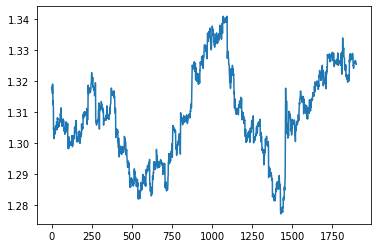

In [209]:
# Y del dataset de pruebas
pyplot.plot(y_test_np)

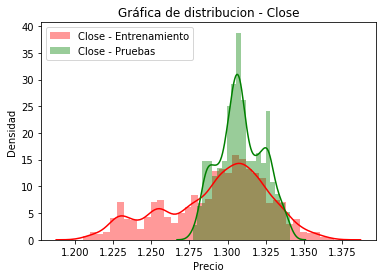

In [210]:
sns.distplot(y_train_np, color='red', label = 'Close - Entrenamiento');
sns.distplot(y_test_np, color='green', label = 'Close - Pruebas');
plt.title('Gráfica de distribucion - Close')
plt.xlabel('Precio')
plt.ylabel('Densidad')
plt.legend()
plt.show()

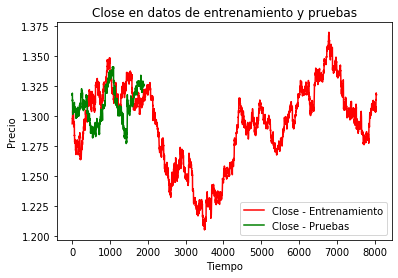

In [211]:

# Y de Val y Test comparados
pyplot.plot(y_train_np, color = 'red', label = 'Close - Entrenamiento')
#pyplot.plot(y_test_np)
pyplot.plot(y_test_np, color = 'green', label = 'Close - Pruebas')

plt.title('Close en datos de entrenamiento y pruebas')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()


In [212]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

51
11


In [213]:
regressior = Sequential()

regressior.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 120, activation = 'relu'))
#regressior.add(Dropout(0.2))

regressior.add(Dense(units = 1))


In [214]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [215]:
regressior.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])

In [216]:
regressior.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 51, 51)            12852     
_________________________________________________________________
lstm_9 (LSTM)                (None, 51, 60)            26880     
_________________________________________________________________
lstm_10 (LSTM)               (None, 51, 80)            45120     
_________________________________________________________________
lstm_11 (LSTM)               (None, 120)               96480     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 121       
Total params: 181,453
Trainable params: 181,453
Non-trainable params: 0
_________________________________________________________________


In [217]:
#Model check pointer para almacenar el modelo cada epoca
checkpointer = ModelCheckpoint(filepath=source_data + '/model-{epoch:02d}.hdf5', verbose=1)

In [218]:
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np), callbacks=[checkpointer], shuffle=True)
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)



Train on 8049 samples
Epoch 1/10
8049/8049 [==============================] - 67s 8ms/sample - loss: 1.1856 - mean_squared_error: 1.1856 - mean_absolute_error: 0.7549 - mean_absolute_percentage_error: 58.4190 - cosine_proximity: 0.9920
Epoch 2/10
8049/8049 [==============================] - 58s 7ms/sample - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0331 - mean_absolute_percentage_error: 2.5842 - cosine_proximity: 1.0000
Epoch 3/10
8049/8049 [==============================] - 76s 9ms/sample - loss: 5.3710e-04 - mean_squared_error: 5.3710e-04 - mean_absolute_error: 0.0165 - mean_absolute_percentage_error: 1.2883 - cosine_proximity: 1.0000
Epoch 4/10
8049/8049 [==============================] - 74s 9ms/sample - loss: 2.8736e-04 - mean_squared_error: 2.8736e-04 - mean_absolute_error: 0.0120 - mean_absolute_percentage_error: 0.9393 - cosine_proximity: 1.0000
Epoch 5/10
8049/8049 [==============================] - 71s 9ms/sample - loss: 1.4453e-04 - mean_squared_erro

In [219]:
MODEL_NAME = "03_marzo_model_11Features.hdf5"

regressior.save( source_data + MODEL_NAME)


In [220]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])


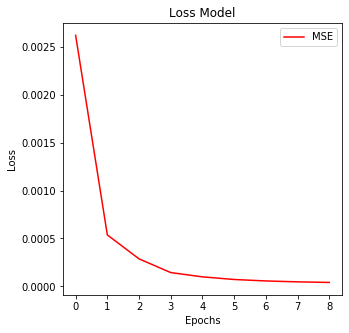

In [221]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
#plt.plot(history.history['val_loss'][1:], color = 'blue', label = 'Val_Loss')
plt.plot(history.history['mean_squared_error'][1:], color = 'red', label = 'MSE')
#plt.plot(history.history['mean_absolute_error'][1:], color = 'blue', label = 'MAE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

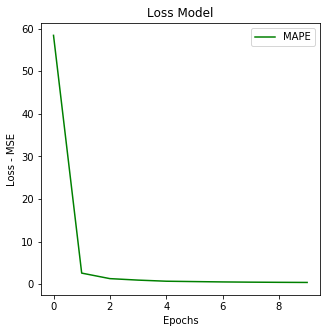

In [222]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
plt.plot(history.history['mean_absolute_percentage_error'][0:], color = 'green', label = 'MAPE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss - MSE')
plt.legend()
plt.show()


In [223]:
#Load Model
#filepath = os.path.join(source_data, r'final_model_100Epochs_3Dic.hdf5')
filepath = os.path.join(source_data, MODEL_NAME)
print(filepath)
model = tf.keras.models.load_model(filepath)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/../../Datasets/EURUSD/ene2004_nov2019/03_marzo_model_11Features.hdf5


In [224]:
y_test_pred = model.predict(X_test_np)
y_test_pred.shape

(1900, 1)

In [225]:
y_train_pred = model.predict(X_train_np)
y_train_pred.shape

(8049, 1)

(1900,)
(1900, 1)


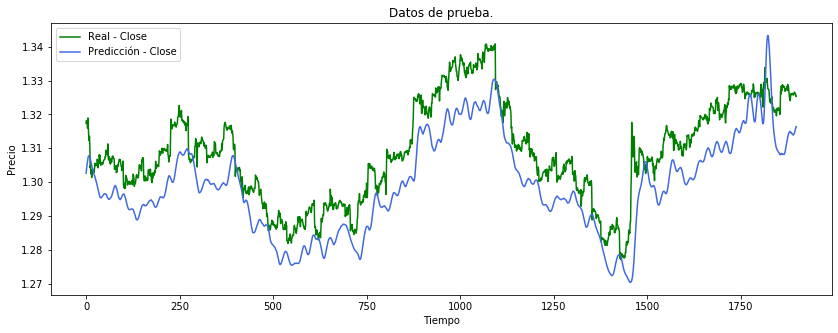

In [226]:
print(y_test_np.shape)
print(y_test_pred.shape)
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test_np[:], color = 'green', label = 'Real - Close')
plt.plot(y_test_pred[:], color = 'royalblue', label = 'Predicción - Close')
plt.title('Datos de prueba.')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()


In [227]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [228]:
print('Test MAE:', mean_absolute_error(y_test_np, y_test_pred))#Mean Absolute Error
print('Test RMSE:',np.sqrt(mean_squared_error(y_test_np, y_test_pred)))#Root Mean Squared Error
print('Test MSE:',mean_squared_error(y_test_np, y_test_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_test_np, y_test_pred))#Mean Absolute Percentaje Error
print('Test R2:',r2_score(y_test_np, y_test_pred))#R2 Score


Test MAE: 0.009729934678328665
Test RMSE: 0.010880692087497685
Test MSE: 0.00011838946030293473
Test MAPE: 1.3692071070409058
Test R2: 0.43401143976170076


(1899,)
(1899, 1)


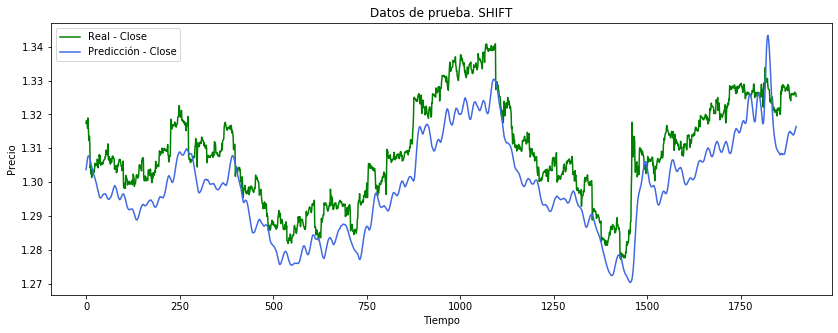

In [229]:
#shift 
y_test_np2 = np.delete(y_test_np, -1)


print(y_test_np2.shape)
print(y_test_pred[1:].shape)
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test_np2, color = 'green', label = 'Real - Close')
plt.plot(y_test_pred[1:], color = 'royalblue', label = 'Predicción - Close')
plt.title('Datos de prueba. SHIFT')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()

In [230]:
#SHIFT
print('SHIFT Test MAE:', mean_absolute_error(y_test_np2, y_test_pred[1:]))#Mean Absolute Error
print('SHIFT Test RMSE:',np.sqrt(mean_squared_error(y_test_np2, y_test_pred[1:])))#Root Mean Squared Error
print('SHIFT Test MSE:',mean_squared_error(y_test_np2, y_test_pred[1:]))#Mean Squared Error
print('SHIFT Test MAPE:',mean_absolute_percentage_error(y_test_np2, y_test_pred[1:]))#Mean Absolute Percentaje Error
print('SHIFT Test R2:',r2_score(y_test_np2, y_test_pred[1:]))#R2 Score


SHIFT Test MAE: 0.009706455736426443
SHIFT Test RMSE: 0.010785586849115632
SHIFT Test MSE: 0.00011632888367981608
SHIFT Test MAPE: 1.369096012395265
SHIFT Test R2: 0.44376763437208055


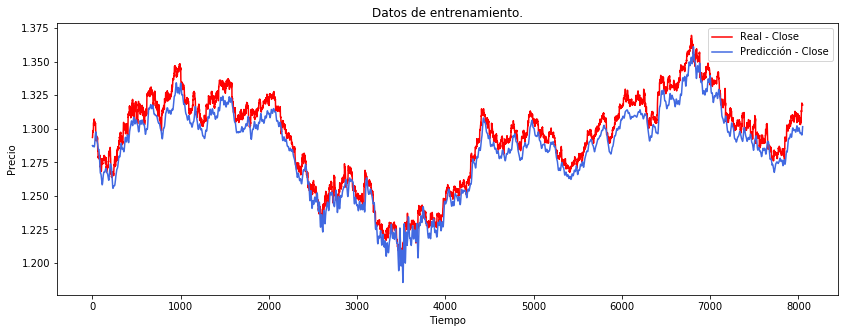

In [231]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_train_np, color = 'red', label = 'Real - Close')
plt.plot(y_train_pred, color = 'royalblue', label = 'Predicción - Close')
plt.title('Datos de entrenamiento.')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()


In [232]:
print('Train MAE:', mean_absolute_error(y_train_np, y_train_pred))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(y_train_np, y_train_pred)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(y_train_np, y_train_pred))#Mean Squared Error
#print('Test MAPE:',mean_absolute_percentage_error(y_train_np, y_train_pred))#Mean Absolute Percentaje Error
print('Test R2:',r2_score(y_train_np, y_train_pred))#R2 Score
y_train_np2 = np.delete(y_train_np, -1)
print('Test R2 (-1):',r2_score(y_train_np2, y_train_pred[1:]))#R2 Score

Train MAE: 0.009140185373576179
Train RMSE: 0.01039589533515391
Train MSE: 0.00010807463981947482
Test R2: 0.902607099756215
Test R2 (-1): 0.9043384874211281


In [237]:
# Section to implement the ARIMA model from the library statsmodels.tsa.arima_model
# fit model
#model = ARIMA(series, order=(5,1,0))
train, test = y_train_np, y_test_np
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


/Users/marami3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/marami3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/marami3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/marami3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/marami3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimizat

Test MSE: 0.000


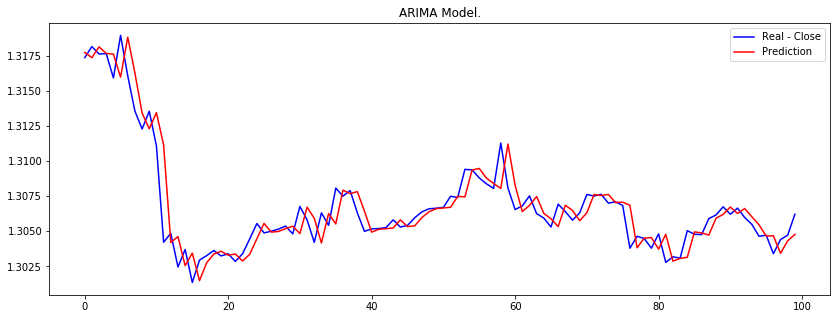

In [238]:
# plot
plt.figure(figsize=(14,5))
pyplot.plot(test[0:100], color='blue',label = 'Real - Close')
pyplot.plot(predictions[0:100], color='red',label = 'Prediction')
plt.title('ARIMA Model.')
plt.legend()
pyplot.show()

In [239]:
print('Train MAE:', mean_absolute_error(test, predictions))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(test, predictions)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(test, predictions))#Mean Squared Error

Train MAE: 0.0009024658862042764
Train RMSE: 0.0014721935197721378
Train MSE: 2.1673537596590758e-06
